In [1]:
from dateutil.relativedelta import *
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import os
import sys
from pprint import pprint
from pylab import rcParams

In [2]:
sys.path.append("../")
import core.tools.json_rec as json_rec

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [4]:
import tools
from typing import List, Tuple

In [5]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

In [6]:
PARAMS = dict(
    COL_NAME = "UNRATE",
    P = 6,
    NUM_TIME_STEPS = 6,
    D = 1,
    Q = None,
    NUM_INPUTS = 1,
    NUM_OUTPUTS = 1,
    LR = 0.01,
    EPOCHS = None,
    PATIENT = 100,
    EPSILON = 1e-8
)

In [7]:
globals().update(PARAMS)

In [8]:
df = pd.read_csv("./data/UNRATE.csv", index_col=0, parse_dates=True)
# df["DATE"] = pd.to_datetime(df["DATE"])
df.columns = [COL_NAME]
print(df.dtypes)
df.head()
# month_df = df.resample("M").mean().head()

UNRATE    float64
dtype: object


,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [9]:
from tools import gen_slp_sequential
def gen_slp_point(diff, num_time_steps):
    slp_sequential = gen_slp_sequential(
        diff,
        num_time_steps=num_time_steps
    )
    instances = [
        (x, y[-1], t)
        for x, y, t in slp_sequential
    ]
    return instances

In [10]:
diff = df.diff()  #  Take the first order differenced.
diff.dropna(inplace=True)
slp_seq = tools.gen_slp_sequential(diff, num_time_steps=P)
slp_pt = gen_slp_point(diff, num_time_steps=P)

Failed time step ignored: 845
Failed time step ignored: 846
Failed time step ignored: 847
Failed time step ignored: 848
Failed time step ignored: 849
Failed time step ignored: 850
Failed time step ignored: 845
Failed time step ignored: 846
Failed time step ignored: 847
Failed time step ignored: 848
Failed time step ignored: 849
Failed time step ignored: 850


In [11]:
len(slp_pt)

845

In [12]:
X = np.squeeze([p[0] for p in slp_pt]).reshape(-1, P)
y = np.squeeze([p[1] for p in slp_pt]).reshape(-1, NUM_OUTPUTS)
ts = [p[2] for p in slp_pt]

In [13]:
print(X.shape)
print(y.shape)
total = len(y)

(845, 6)
(845, 1)


In [14]:
X_train, y_train, ts_train =\
X[:int(total*0.6), :],\
y[:int(total*0.6), :],\
ts[:int(total*0.6)]

In [15]:
X_val, y_val, ts_val =\
X[int(total*0.6): int(total*0.8), :],\
y[int(total*0.6): int(total*0.8), :],\
ts[int(total*0.6): int(total*0.8)]

In [16]:
X_test, y_test, ts_test =\
X[int(total*0.8):, :],\
y[int(total*0.8):, :],\
ts[int(total*0.8):]

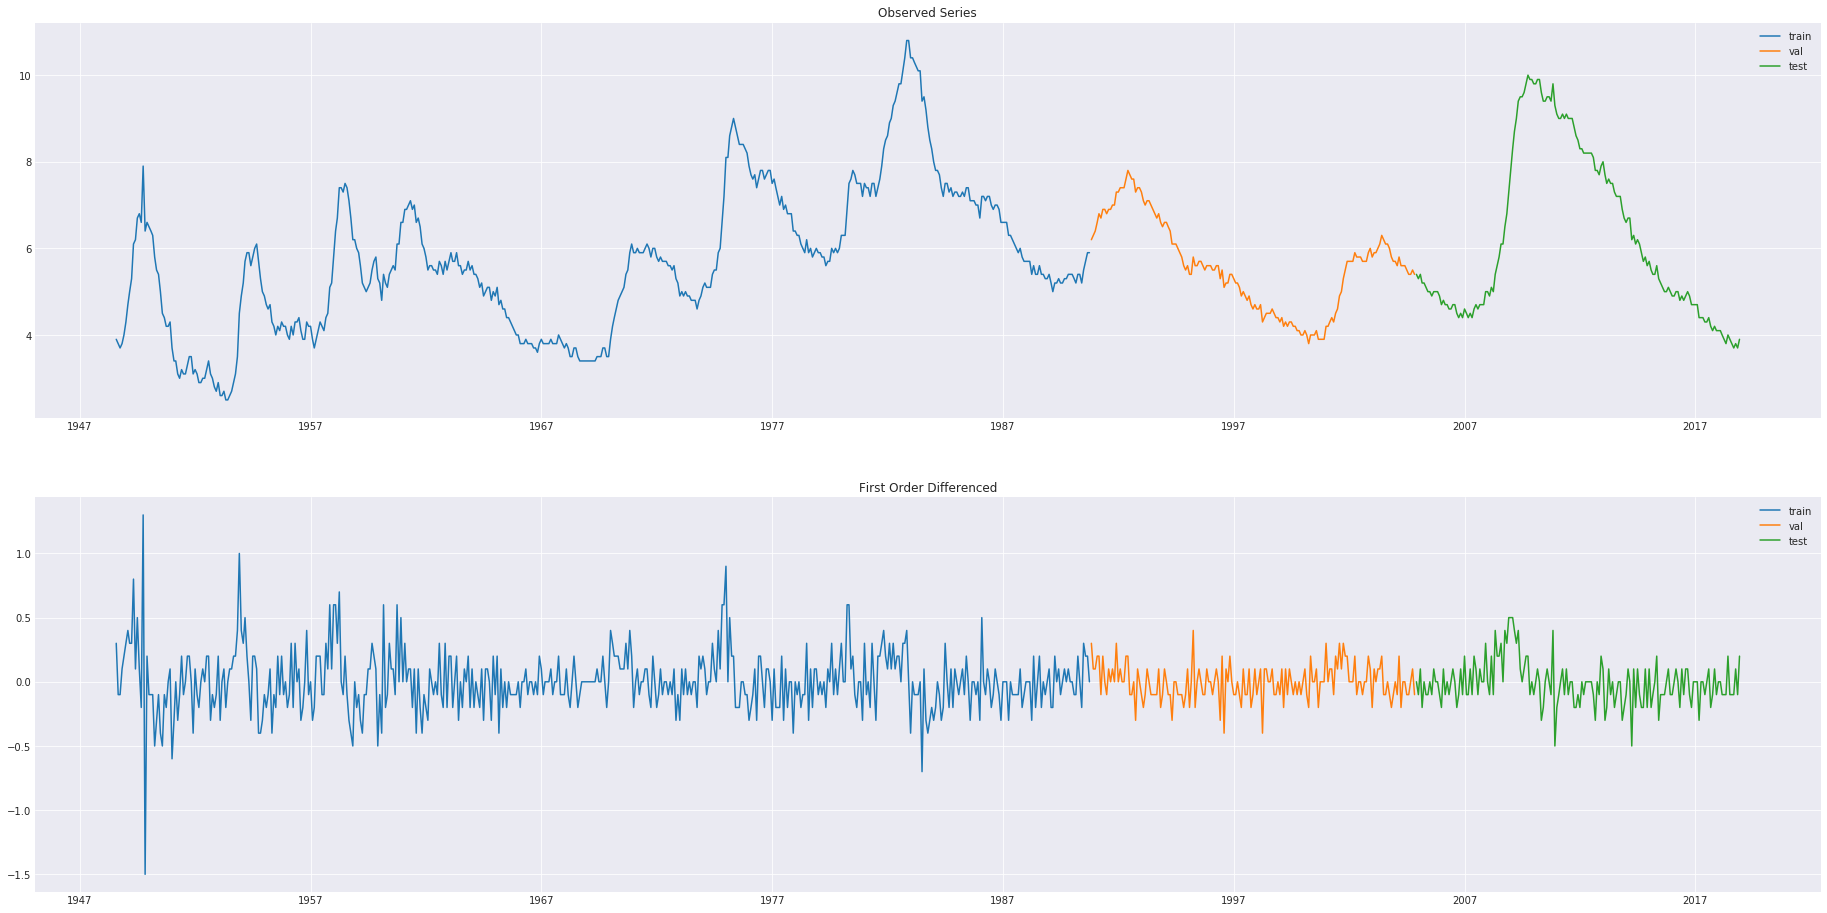

In [17]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
ax1 = plt.subplot(2, 1, 1)
plt.title("Observed Series")
plt.plot(ts_train, df[COL_NAME][ts_train], label="train")
plt.plot(ts_val, df[COL_NAME][ts_val], label="val")
plt.plot(ts_test, df[COL_NAME][ts_test], label="test")
plt.legend()
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("First Order Differenced")
plt.plot(ts_train, y_train, label="train")
plt.plot(ts_val, y_val, label="val")
plt.plot(ts_test, y_test, label="test")
plt.legend()
plt.grid(True)

# plt.savefig(PATH_COL["FIG_PATH"] + "/raw.png", dpi=600)
plt.show()

In [18]:
tf.reset_default_graph()
with tf.name_scope("DATA_IO"):
    X = tf.placeholder(
        tf.float32,
        [None, NUM_TIME_STEPS],
        name="FEATURE"
    )
    
    y = tf.placeholder(
        tf.float32,
        [None, NUM_OUTPUTS],
        name="LABEL"
    )

In [19]:
NEURONS = [256, 512]
with tf.name_scope("DENSE"):
    W1 = tf.Variable(tf.random_normal([NUM_TIME_STEPS, NEURONS[0]], name="W1"))
    b1 = tf.Variable(tf.random_normal([1, NEURONS[0]], name="b1"))
    
    W2 = tf.Variable(tf.random_normal([NEURONS[0], NEURONS[1]], name="W2"))
    b2 = tf.Variable(tf.random_normal([1, NEURONS[1]], name="b2"))
    
    W3 = tf.Variable(tf.random_normal([NEURONS[1], NUM_OUTPUTS]), name="W3")
    b3 = tf.Variable(tf.random_normal([1, NUM_OUTPUTS]), name="W3")
    
    a1 = tf.sigmoid(tf.matmul(X, W1) + b1)
    a2 = tf.sigmoid(tf.matmul(a1, W2) + b2)
    reg_outputs = tf.matmul(a2, W3) + b3

In [20]:
with tf.name_scope("METRICS"):
    loss = tf.reduce_mean(
        tf.square(y - reg_outputs),
        name="MSE"
    )

In [21]:
optimizer = tf.train.AdamOptimizer(
    learning_rate=LR,
    name="Adam"
)
train = optimizer.minimize(loss)

In [22]:
start = datetime.datetime.now()
counter = 0
val_mse = np.inf
if EPOCHS is None:
    EPOCHS = int(100000)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(EPOCHS):
#         tools.progbar(e+1, EPOCHS, 30)
        sess.run(
            train,
            feed_dict={X: X_train, y: y_train}
        )
        # ==== Automatically Stop Training ====
        val_mse_last = val_mse
        train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
        val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
        if (val_mse_last - val_mse) < PARAMS["EPSILON"]:
            # if the improvement is less than epsilon.
            counter += 1
        else:
            counter -= 1
            counter = max(counter, 0)

        if counter >= PARAMS["PATIENT"]:
            print(f"Break training at epoch={e}")
            break
        # ==== End ====    

        if e % 100 == 0:
            print(f"Epoch={e}: train_MSE={train_mse}, val_MSE={val_mse}, current_patient={counter}")
    make_prediction = lambda data: sess.run(reg_outputs, feed_dict={X: data})
    pred_train = make_prediction(X_train)
    pred_val = make_prediction(X_val)
    pred_test = make_prediction(X_test)

print(f"Time taken: {datetime.datetime.now() - start}")

Epoch=0: train_MSE=232.49649047851562, val_MSE=223.42799377441406, current_patient=0
Epoch=100: train_MSE=0.09514822065830231, val_MSE=0.0701434537768364, current_patient=2
Epoch=200: train_MSE=0.05560840666294098, val_MSE=0.03874310106039047, current_patient=0
Epoch=300: train_MSE=0.04216522350907326, val_MSE=0.030227914452552795, current_patient=0
Epoch=400: train_MSE=0.036202166229486465, val_MSE=0.026943087577819824, current_patient=0
Epoch=500: train_MSE=0.03302382305264473, val_MSE=0.025769628584384918, current_patient=0
Epoch=600: train_MSE=0.030685579404234886, val_MSE=0.02537873014807701, current_patient=0
Epoch=700: train_MSE=0.028793305158615112, val_MSE=0.025302229449152946, current_patient=0
Epoch=800: train_MSE=0.02744576521217823, val_MSE=0.025228358805179596, current_patient=0
Epoch=900: train_MSE=0.026350080966949463, val_MSE=0.02509271167218685, current_patient=0
Epoch=1000: train_MSE=0.025525754317641258, val_MSE=0.025179609656333923, current_patient=1
Epoch=1100: tr

In [23]:
dfp_train = pd.DataFrame(data=pred_train, index=ts_train)
dfp_val = pd.DataFrame(data=pred_val, index=ts_val)
dfp_test = pd.DataFrame(data=pred_test, index=ts_test)

In [24]:
pred_diff = pd.concat([dfp_train, dfp_val, dfp_test])
pred_diff.columns = [COL_NAME]
pred_raw = tools.inv_diff(pred_diff, df)

In [25]:
def naive_prediction(y: pd.DataFrame) -> pd.DataFrame:
    ts, pred = [], []
    for t, x in zip(y.index, y.values):
        ts.append(t + relativedelta(months=+1))
        pred.append(x)
    naive_pred = pd.DataFrame(pred, index=ts)
    return naive_pred

naive_pred_val = naive_prediction(pd.DataFrame(y_val, index=ts_val))
naive_pred_test = naive_prediction(pd.DataFrame(y_test, index=ts_test))

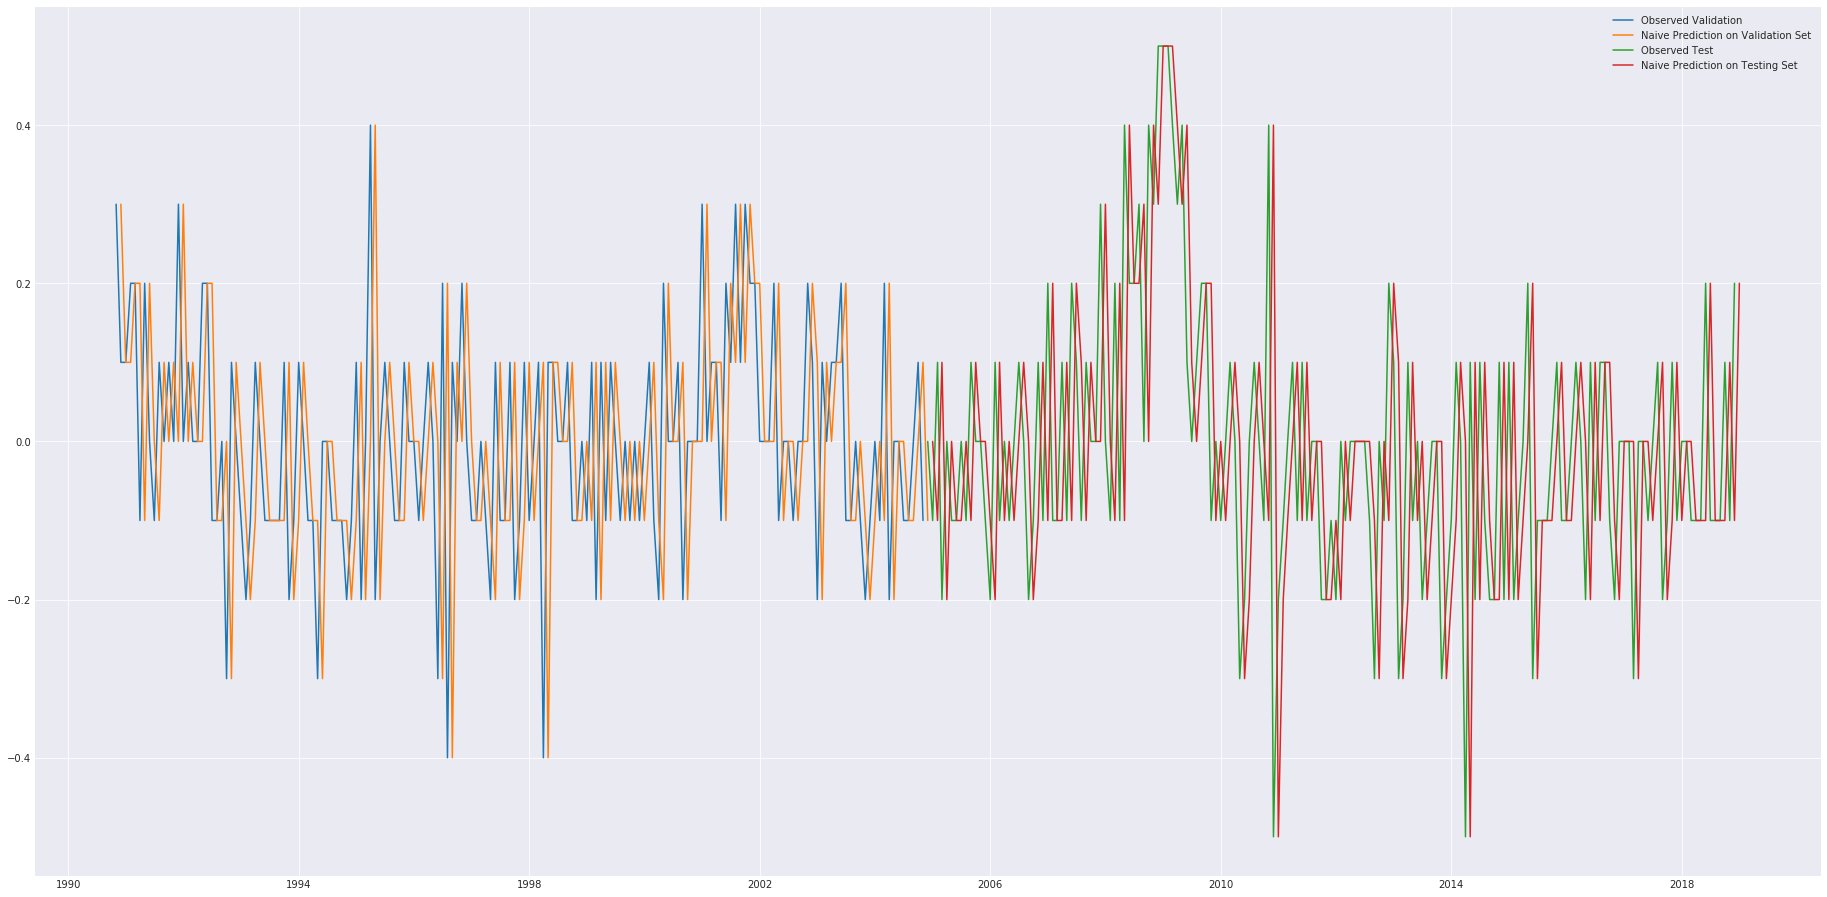

In [26]:
rcParams["figure.figsize"] = (32, 16)
plt.plot(pd.DataFrame(y_val, index=ts_val), label="Observed Validation")
plt.plot(naive_pred_val, label="Naive Prediction on Validation Set")

plt.plot(pd.DataFrame(y_test, index=ts_test), label="Observed Test")
plt.plot(naive_pred_test, label="Naive Prediction on Testing Set")

plt.legend()
plt.grid(True)
plt.show()

In [27]:
mse = lambda pred, label: np.mean((label - pred) ** 2)

**Definition** A *naive forecaster* is defined as
$$
\forall t \in T,\ f_{t,1} := y_{t}
$$

In [28]:
def evaluate_naive_forecast(sequence: pd.DataFrame) -> float:
    diff = sequence.diff()
    diff.dropna(inplace=True)
    mse = np.mean(diff.values ** 2)
    return mse

In [29]:
c =  diff["UNRATE"][ts_val].diff()
c.dropna(inplace=True)
np.mean(c.values ** 2)

0.038571428571428604

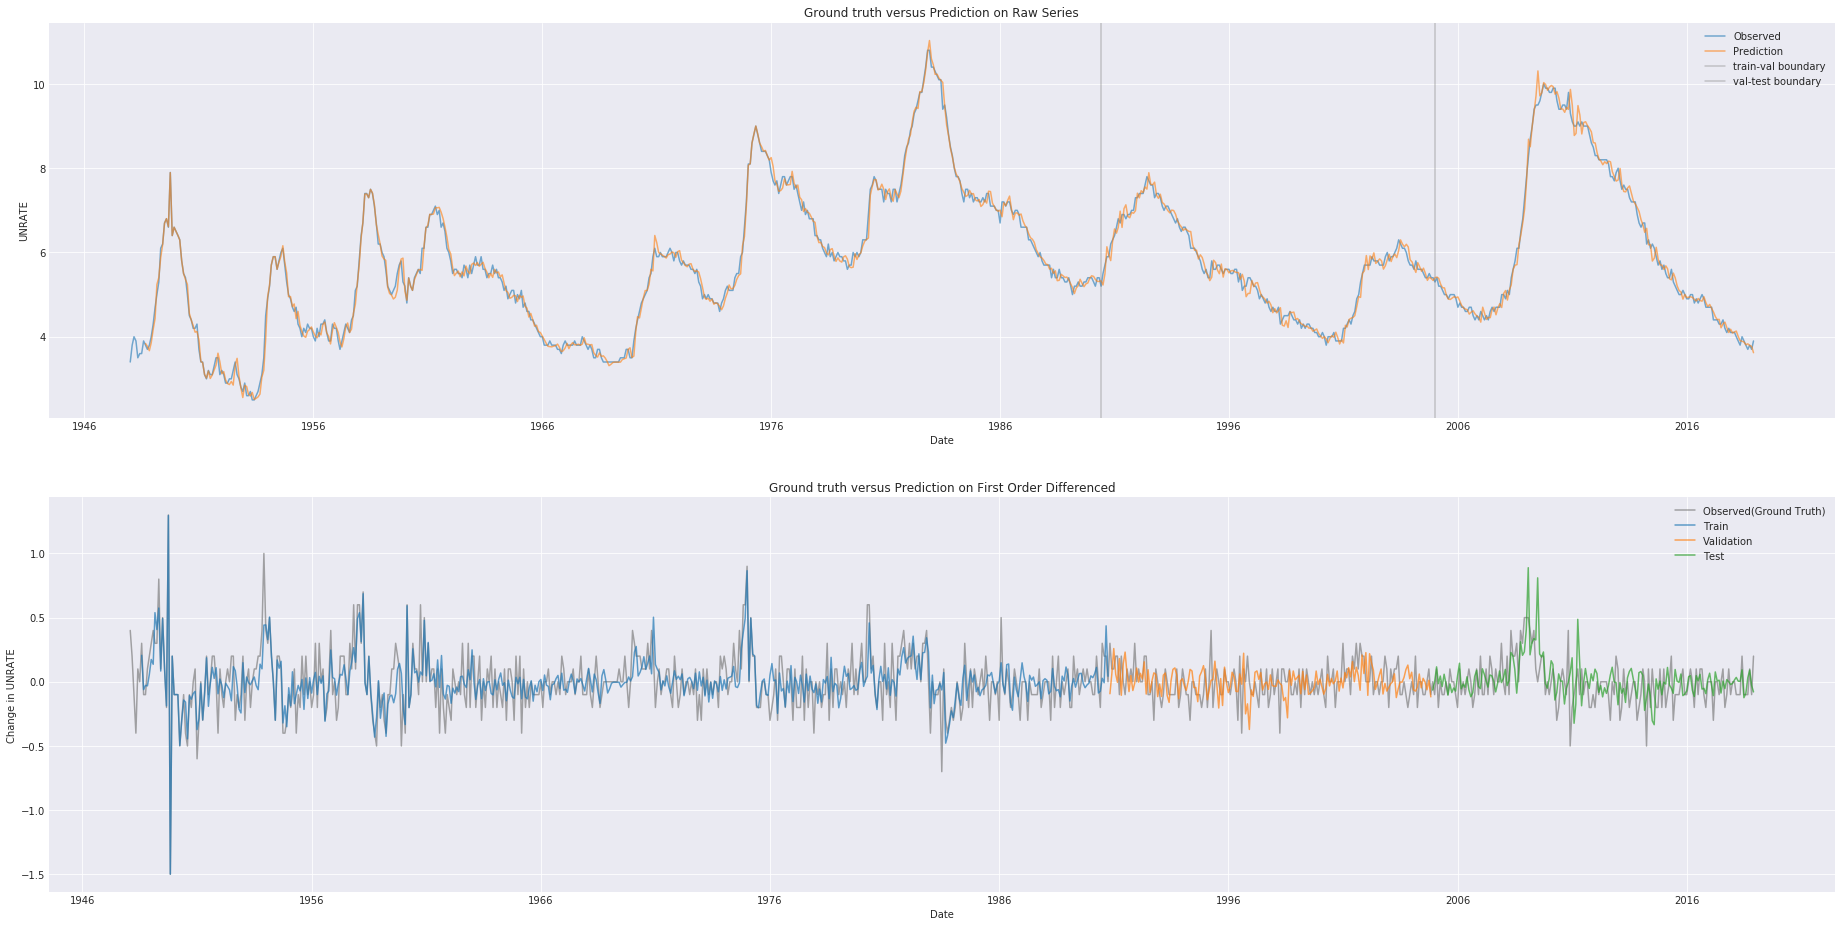

In [30]:
plt.close()
rcParams["figure.figsize"] = (32, 16)
# ==== Raw ====
ax1 = plt.subplot(2, 1, 1)
plt.title("Ground truth versus Prediction on Raw Series")
plt.plot(df, label="Observed", alpha=.6)
plt.plot(pred_raw, label="Prediction", alpha=.6)

plt.axvline(x=diff.index[len(X_train)+1], color="grey", alpha=.4, label="train-val boundary")
plt.axvline(x=diff.index[-len(X_test)+1], color="grey", alpha=.4, label="val-test boundary")
plt.grid(True)

ax1.set_xlabel("Date")
ax1.set_ylabel("UNRATE")
plt.legend()

# ==== First order differenced ====
ax2 = plt.subplot(2, 1, 2)
rcParams["figure.figsize"] = (32, 16)
plt.title("Ground truth versus Prediction on First Order Differenced")
plt.plot(diff, label="Observed(Ground Truth)", color="grey", alpha=.7)
plt.plot(dfp_train, label="Train", alpha=.7)
plt.plot(dfp_val, label="Validation", alpha=.7)
plt.plot(dfp_test, label="Test", alpha=.7)
plt.legend()

ax2.set_xlabel("Date")
ax2.set_ylabel("Change in UNRATE")
plt.grid(True)

# plt.savefig(PATH_COL["FIG_PATH"] + "/prediction.png", dpi=600)
plt.show()